# Models

In [1]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
import sys
import numpy
import math
numpy.set_printoptions(threshold=sys.maxsize)

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn import metrics

from sklearn.feature_selection import RFE

from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as ltb

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectPercentile
from sklearn.metrics import confusion_matrix, classification_report, f1_score, auc, roc_curve, roc_auc_score, precision_score, recall_score, balanced_accuracy_score
from numpy.random import seed
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold, StratifiedKFold
seed(42)
import tensorflow as tf
tf.random.set_seed(38)
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers import Dense

import shap
from xgboost import plot_importance

2022-03-22 03:02:47.823051: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-22 03:02:47.823085: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# load pre porcessed data
df = pd.read_csv('../prepross_data/data.csv')


#### Filterout the paper described patient set

In [3]:
# filter dataset as describe in paper
def get_filter_by_age_diabDur(df, age, diabDur):
    filter_patients = df[(df["AgeAtConsent"] >= age) & (df["diagDuration"] > diabDur)] 
#     filter_patients=filter_patients.drop_duplicates(subset="PtID",keep="first") 
    print(f'Number of patients whos age is {age}+ and diabetics duration greater than {diabDur}  is -> {filter_patients.PtID.size}')
    return filter_patients

df = get_filter_by_age_diabDur(df, 26, 2)

Number of patients whos age is 26+ and diabetics duration greater than 2  is -> 7155


In [4]:
# remove all unknown data
df.drop(df[df.SHSeizComaPast12mos == 2].index, inplace=True)
# df.drop(df[df.Pt_SevHypoEver == 2].index, inplace=True)

### for SH events prediction pre processing


In [5]:
# check patients count with SHSeizComaPast12mos and not Pt_SevHypoEver
# df.loc[(df['SHSeizComaPast12mos']==0) & (df['Pt_SevHypoEver']==0)]

In [6]:
y_label = 'SHSeizComaPast12mos' 
# possible labels Pt_SevHypoEver, SHSeizComaPast12mos, DKAPast12mos, Depression, DiabNeuro, DKADiag

In [7]:
# fill null value according to the other parameters

# fill with 0 - if data not available probably patient has not that medical condition
def fill_y_label(row):

    if(math.isnan(row['SHSeizComaPast12mos'])):
        if((row['NumSHSeizComaPast12mos'] >= 1)):
            row[y_label] = 0
        else:
            row[y_label] = 1
    return row


df = df.apply(fill_y_label, axis=1)


In [8]:
# get possible values in column including nan
def get_possible_vals_with_nan(df, colName):
    list_val =df[colName].unique().tolist()
    return list_val


# {'1.Yes': 0, '2.No': 1, "3.Don't know": 2}

print(get_possible_vals_with_nan(df, y_label))


[1.0, 0.0]


In [9]:
pd.options.display.max_rows = 100

def get_missing_val_percentage(df):
    return (df.isnull().sum()* 100 / len(df))


missing_per = get_missing_val_percentage(df)

# get missing values < threshold feature name list
variables = df.columns
thresh = 40
variable = [ ]
var = []
for i in range(df.columns.shape[0]):
    if missing_per[i]<= thresh: #setting the threshold as 40%
        variable.append(variables[i])
    else :
        var.append(variables[i])
        
print("variables missing vals < threshold")     
print(variable)
print("Length: ", len(variable))

print()
print("variables missing vals > threshold")     
print(var)
print("Length: ", len(var))

variables missing vals < threshold
['PtID', 'Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag', 'Pt_NumHospDKA', 'Pt_InsulinRecMethod', 'Pt_InsLev1PerDay', 'Pt_InsLev2PerDay', 'Pt_InsLant1PerDay', 'Pt_InsLant2PerDay', 'Pt_InsUnk', 'Pt_MealBolusMethod', 'Pt_InsCarbRat', 'Pt_InsCarbRatBrkfst', 'Pt_InsCarbRatLunch', 'Pt_InsCarbRatDinn', 'Pt_BolusDecCntCarb', 'Pt_BolusDaySnackFreq', 'Pt_BedtimeSnack', 'Pt_ChkBldSugPriBolus', 'Pt_MissInsDoseFreq', 'Pt_NumBolusDayUnk', 'Pt_InjLongActDayNotUsed', 'Pt_InjShortActDayNotUsed', 'Pt_LongActInsDayNotUsed', 'Pt_NumMeterCheckDay', 'Pt_DLoadHGMFreq', 'Pt_LogBook', 'Pt_ChkKetones', 'Pt_CGMUse', 'Pt_CGMStopUse', 'Pt_LastEyeExamPart', 'Pt_DiabRetTrtPart', 'Pt_LegBlind', 'Pt_HealthProfDiabEdu', 'Pt_GlutFreeDiet', 'Pt_CeliacDr', 'Pt_HighBldPrTrt', 'Pt_Smoke', 'Pt_GenHealth', 'Pt_StressDiab', 'Pt_AnnualInc', 'Pt_HouseholdCnt', 'Pt_InsPriv', 'Pt_MaritalStatus', 'Pt_EmployStatus', 'Pt_RaceEth', 'HyperglyCritHbA1c', 'HyperglyCritRandGluc', 'ReqInsulinCrit',

In [10]:
# cols_to_del = ['Diab_dur_greater','HbA1C_SH', 'Pt_InsHumalog', 'Pt_InsNovolog', 'Pt_BolusDecCntCarb', 
#                'Pt_BolusBedtimeSnackFreq', 'Pt_InsPumpStartAge', 'Pt_PumpManuf', 'Pt_PumpModel',
#                'Pt_DaysLeavePumpIns', 'Pt_BasInsRateChgDay', 'Pt_NumBolusDay', 'Pt_ReturnPump', 
#                'Pt_InjMethod', 'Pt_InjLongActDay', 'Pt_InjShortActDay', 'Pt_LongActInsDay', 
#                'Pt_ShortActInsDay', 'Pt_PumpStopUse', 'Pt_HealthProfDiabEdu', 'Pt_SmokeAmt', 
#                'Pt_DaysWkEx', 'Pt_MenarcheAge', 'Pt_RegMenstCyc', 'Pt_IrregMenstCycReas',
#                'Pt_CurrPreg', 'Pt_MiscarriageNum', 'Pt_v3NumHospOthReas',
#                'HyperglyCritRandGluc', 'WeightDiag', 'NumDKAOccur', 'TannerNotDone', 'PumpTotBasIns',
#                'HGMNumDays', 'HGMTestCntAvg', 'HGMGlucMean', 'CGMGlucPctBelow70', 'CGMGlucPctBelow60', 
#                'PulseRate', 'InsCarbRatBrkfst', 'InsCarbRatLunch', 'InsCarbRatDinn', 'InsCarbRatDinnNotUsed', 
#                'CGMPctBelow55', 'CGMPctBelow80']

cols_to_del = ['Diab_dur_greater', 'ExamDaysFromConsent']

df.drop(cols_to_del, inplace=True, axis=1)
df.head(10)

,PtID,Pt_InitTrt,Pt_SevHypoEver,Pt_HospDKASinceDiag,Pt_NumHospDKA,Pt_InsulinRecMethod,Pt_InsLev1PerDay,Pt_InsLev2PerDay,Pt_InsLant1PerDay,Pt_InsLant2PerDay,...,CardiacArrhyth,Hemoglob,RheumArth,Osteo,Depression,Anxiety,Psychosis,DiabNeuro,diagDuration,education_level
0,3963.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0876,11.0
4,12505.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.1684,12.0
7,26063.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14.0507,NaN
14,553.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.8549,11.0
15,13365.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56.3915,13.0
20,15799.0,3.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.1739,9.0
24,15966.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0999,12.0
27,6426.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.1704,10.0
34,10659.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.9979,10.0
40,19861.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42.6872,10.0


# Divide Dataset

In [11]:
df = df[['diagDuration','HbA1c','Pt_AnnualInc', 'Pt_InsPriv', 'education_level',
         'InsulinDeliv', 'Pt_Smoke', y_label,
             'Pt_InsCarbRat', 
             'relative_T1D'
            ]]

In [12]:
# df=df.drop('PtID', axis = 1)

In [13]:
def corrX_orig(df, cut = 0.8) :
        
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool))
    
    drop = list()
    
    # For loop implements this pseudocode
    # For every cell in the upper triangle: 
        # If cell.value > 0.6: 
                # If mean(row_correlation) > mean(column_correlation):drop(column)
		# Else: drop(row)
        
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    drop.append(row)
                else: 
                    drop.append(col)
    
    drop_set = list(set(drop))
    dropcols_names = list(df.columns[[item for item in drop_set]])
    
    return(dropcols_names)

cols_to_drop = corrX_orig(df)


In [14]:

# df.drop(['Lipoatrophy',
#  'AgeAtConsent',
#  'InsCarbRatDinn',
#  'InsNovolog',
#  'CGMGlucPctBelow60'], inplace=True, axis=1)
# df.head(10)


In [15]:

def divide_data(df,label):
    Y = df[label]
    X = df.drop(label, axis=1)
    return X, Y

X, Y = divide_data(df, y_label)


In [16]:
Y.unique()

array([1., 0.])

# Feature Selection

In [17]:
shape = np.shape(X) 
feature = 25 #shape[1] 
n_classes = 2


In [18]:
seed(42)
tf.random.set_seed(38)
# Save original data set
original_X = X

# Split into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, stratify=Y, random_state=123)

# if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y will make sure that your random split has 25% of 0's and 75% of 1's.
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25)


In [19]:
len(Y_train == 0.0)
unique, counts = numpy.unique(Y_train.to_numpy(), return_counts=True)
print("Train - ", unique, counts)

unique_test, counts_test = numpy.unique(Y_test.to_numpy(), return_counts=True)
print("Test - ", unique_test, counts_test)


Train -  [0. 1.] [ 154 4837]
Test -  [0. 1.] [  51 1613]


# Imputations

<AxesSubplot:>

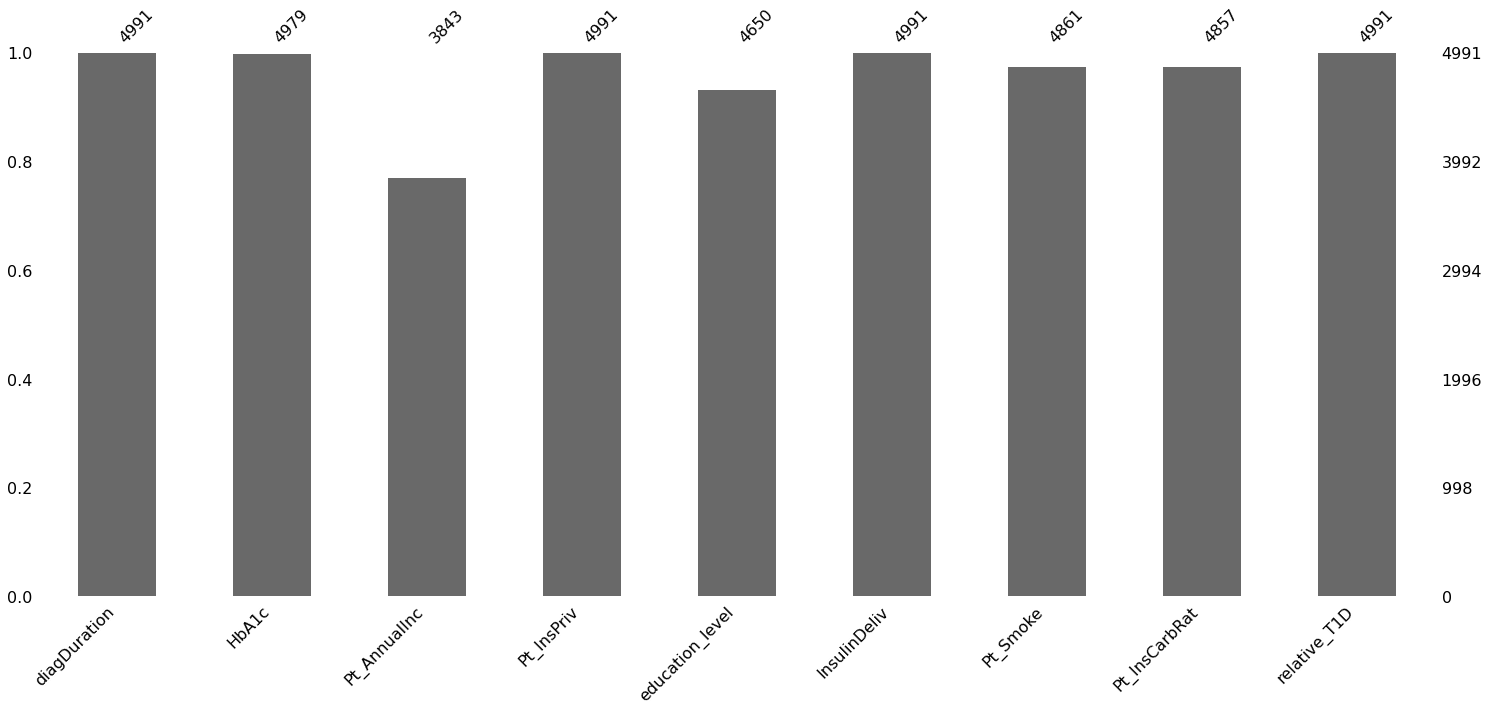

In [20]:
import missingno as msno
msno.bar(X_train)

### XGB with missing values

In [21]:
def plot_roc_curve(fpr, tpr, optimal_idx):
    plt.figure(figsize=(10,5))
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='black', label='Best') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [22]:
# use only for XGB classifier with missing values
# X_train_copy = X_train.drop(['SHSeizComaPast12mos', 'NumSHSeizComaPast12mos'], axis=1)
# X_test_copy = X_test.drop(['SHSeizComaPast12mos', 'NumSHSeizComaPast12mos'], axis=1)

X_train_copy = X_train.copy()
X_test_copy = X_test.copy()


# if('NumSHSeizComaPast12mos' in X_train.columns):
#     X_train_copy = X_train_copy.drop(['NumSHSeizComaPast12mos'], axis=1)
#     X_test_copy = X_test_copy.drop([ 'NumSHSeizComaPast12mos'], axis=1)
    
# if('Pt_v3NumSHSeizComa' in X_train.columns):
#     X_train_copy = X_train_copy.drop(['Pt_v3NumSHSeizComa'], axis=1)
#     X_test_copy = X_test_copy.drop(['Pt_v3NumSHSeizComa'], axis=1)
    
# if('Pt_SevHypoEver' in X_train.columns):
#     X_train_copy = X_train_copy.drop(['Pt_SevHypoEver'], axis=1)
#     X_test_copy = X_test_copy.drop(['Pt_SevHypoEver'], axis=1)

# feature_list_m = ['Pt_SevHypoEver', 'AcanNigrDiag', 'Pt_BasInsRateChgDay', 'HighLDL',
#                   'Pt_CGMUse', 'Pt_v3NumHospOthReas', 'DiabRetTrt', 'FootUlcerPres', 'Pt_LegBlind',
#                   'Pt_ChkKetones', 'AcanNigrPres', 'Pt_MissInsDoseFreq', 'InsOther', 'LastEyeExam', 'education_level',
#                   'Pt_InjLongActDay', 'Pt_SmokeAmt', 'Pt_GenHealth', 'Pt_InjMethod', 'Pt_HighBldPrTrt',
#                   'NumOfficeVisits', 'Pt_DaysWkEx', 'Osteo','Pt_CGMStopUse','Pt_NumBolusDay']

# feature_list = ['Pt_InitTrt', 'Pt_SevHypoEver', 'Pt_HospDKASinceDiag',
#        'Pt_InsLev1PerDay', 'Pt_InsLant2PerDay', 'Pt_InsCarbRatDinn',
#        'Pt_PumpManuf', 'Pt_DaysLeavePumpIns', 'Pt_ChkKetones',
#        'Pt_HighBldPrTrt', 'Pt_InsPriv', 'WeightDiag', 'HGMNumDays',
#        'Lypohyper', 'AcanNigrDiag', 'AcanNigrPres', 'NumOfficeVisits',
#        'InsCarbRatLunch', 'LastEyeExam', 'AlbuminStatus', 'RenalFailDial',
#         'CardiacAngio',
#        'diagDuration']
# X_train_copy = X_train_copy[feature_list_m]
# X_test_copy = X_test_copy[feature_list_m]
    

In [23]:
kf = KFold(n_splits= 10, shuffle=False)
train = X_train_copy.copy()
train[y_label] = Y_train.values



from sklearn.model_selection import LeaveOneOut

cv = LeaveOneOut()




def cross_val_with_missing_val(model,n_splits=5):
#     i = 1
#     for train_index, test_index in kf.split(train):
#         X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
#         X_test1 = train.iloc[test_index][X_train_copy.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index][y_label]

#         #Train the model
#         model.fit(X_train1, y_train1) #Training the model
#         print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}")
#         i += 1
#     return model


    

    dfs = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        
        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")

        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1






#     dfs = []
#     y_true, y_pred = list(), list()
#     for train_index, test_index in cv.split(train, Y_train):

#         X_train1 = train.iloc[train_index].loc[:, X_train_copy.columns]
#         X_test1 = train.iloc[test_index].loc[:,X_train_copy.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index].loc[:,y_label]

# #         Train the model
#         model.fit(X_train1, y_train1) #Training the model

    return model



Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.


Accuracy for the fold no. 1 on the test set: 0.968968968968969, doublecheck: 0.968968968968969
Accuracy for the fold no. 2 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 3 on the test set: 0.968937875751503, doublecheck: 0.968937875751503
Accuracy for the fold no. 4 on the test set: 0.968937875751503, doublecheck: 0.968937875751503
Accuracy for the fold no. 5 on the test set: 0.968937875751503, doublecheck: 0.968937875751503

 
 ===========   Train Dataset    =============
train ROC score 0.8656715416070387
Threshold value is: 0.9518724896620614


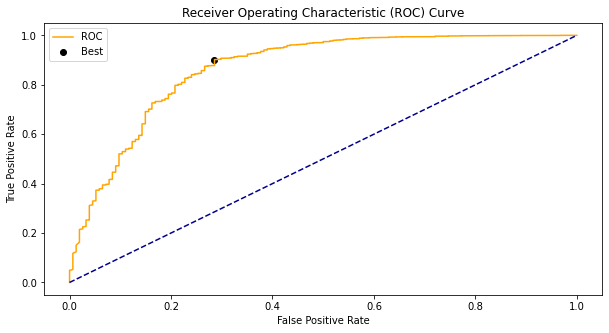

accuracy score:  89.62131837307152
              precision    recall  f1-score   support

         0.0       0.19      0.71      0.30       154
         1.0       0.99      0.90      0.94      4837

    accuracy                           0.90      4991
   macro avg       0.59      0.81      0.62      4991
weighted avg       0.97      0.90      0.92      4991



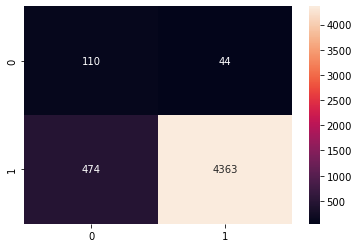

Accuracy of XGB on training set: 0.97


 ===========   Test Dataset    =============
Threshold value is: 0.9726145727239931


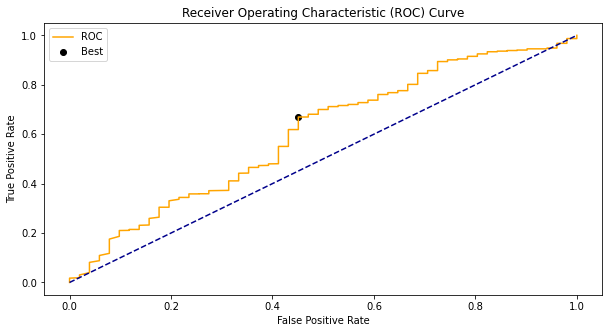

accuracy score:  66.58653846153845
              precision    recall  f1-score   support

         0.0       0.05      0.55      0.09        51
         1.0       0.98      0.67      0.80      1613

    accuracy                           0.67      1664
   macro avg       0.51      0.61      0.44      1664
weighted avg       0.95      0.67      0.77      1664



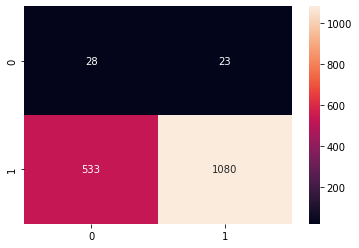

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.6038


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.54901961 0.66955983]
average accuracy:  0.6092897171267764


In [24]:
# HistGradientBoostingClassifier - train with missing values
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier


model= HistGradientBoostingClassifier(loss= 'binary_crossentropy',
                                     learning_rate = 0.01,
                                     max_iter= 100,
                                     )          
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))



print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)



print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)



Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 8 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869

 
 ===========   Train Dataset    =============
train ROC score 0.

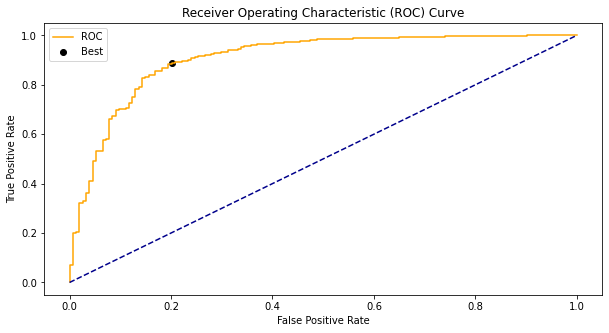

accuracy score:  88.67962332197956
              precision    recall  f1-score   support

         0.0       0.19      0.80      0.30       154
         1.0       0.99      0.89      0.94      4837

    accuracy                           0.89      4991
   macro avg       0.59      0.84      0.62      4991
weighted avg       0.97      0.89      0.92      4991



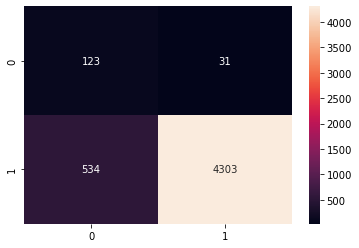

Accuracy of XGB on training set: 0.97


 ===========   Test Dataset    =============
Threshold value is: 2.689589


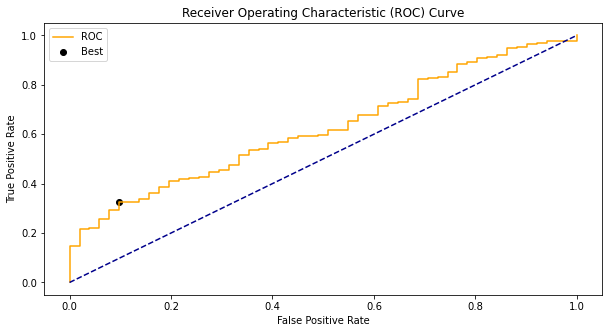

accuracy score:  34.19471153846153
              precision    recall  f1-score   support

         0.0       0.04      0.90      0.08        51
         1.0       0.99      0.32      0.49      1613

    accuracy                           0.34      1664
   macro avg       0.52      0.61      0.28      1664
weighted avg       0.96      0.34      0.48      1664



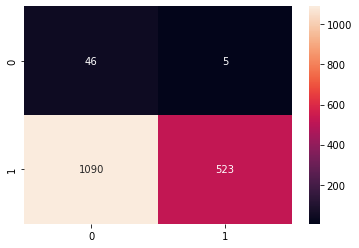

Accuracy of XGB classifier on test set: 0.97


 ===========   ROC    =============
roc_auc = 0.6235


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.90196078 0.32424055]
average accuracy:  0.6131006649404958
f1 0.4885567491826249


In [25]:
# xgboost - train with missing values

model=XGBClassifier(
        use_label_encoder=False, eta = 0.1,#eta between(0.01-0.2)
        max_depth = 4, #values between(3-10)
        max_delta_step = 10,
#         scale_pos_weight = 0.4,
        n_jobs = 0,
        subsample = 0.5,#values between(0.5-1)
        colsample_bytree = 1,#values between(0.5-1)
        tree_method = "auto",
        process_type = "default",
        num_parallel_tree=7,
#         objective = 'binary:logistic', 
        objective='multi:softmax',
        min_child_weight = 4,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
    )

# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model, 10)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

test_acc = model.score(X_test_copy, Y_test)
print('Accuracy of XGB classifier on test set: {:.2f}'
     .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test))


<AxesSubplot:>

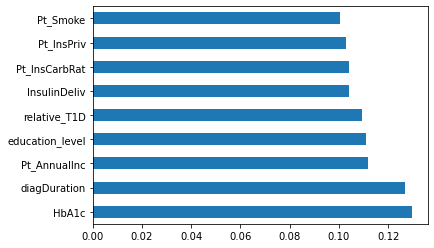

In [26]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:204])
feat_importances.nlargest(20).plot(kind='barh')


Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 8 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869

 
 ===========   Train Dataset    =============
train ROC score 0.

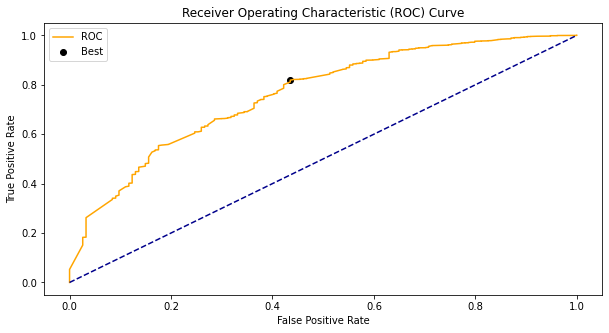

accuracy score:  81.0859547184933
              precision    recall  f1-score   support

         0.0       0.09      0.56      0.16       154
         1.0       0.98      0.82      0.89      4837

    accuracy                           0.81      4991
   macro avg       0.54      0.69      0.52      4991
weighted avg       0.96      0.81      0.87      4991



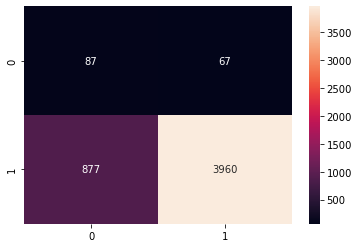

Accuracy of XGB on training set: 0.97


 ===========   Test Dataset    =============
Threshold value is: 0.9688679873305728


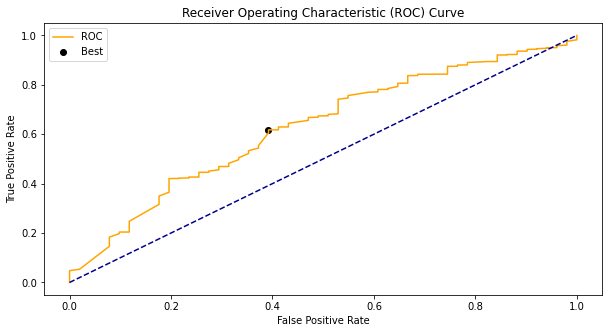

accuracy score:  61.71875
              precision    recall  f1-score   support

         0.0       0.05      0.61      0.09        51
         1.0       0.98      0.62      0.76      1613

    accuracy                           0.62      1664
   macro avg       0.51      0.61      0.42      1664
weighted avg       0.95      0.62      0.74      1664



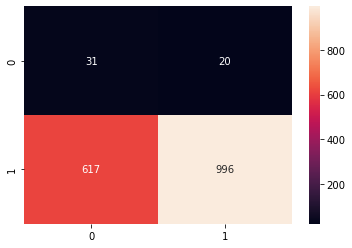



 ===========   ROC    =============
roc_auc = 0.6284


 ===========   Class-wise test accuracy    =============
classwise accuracy [class 0, class 1]:  [0.60784314 0.61748295]
average accuracy:  0.6126630441389203
f1 0.7577025484975276


In [27]:

# xgboost - train with missing values

model=ltb.LGBMClassifier(use_missing = True,
                         learning_rate = 0.01, 
                         max_depth =3, random_state=0 )
                   
# model.fit(X_train_copy,Y_train)
model = cross_val_with_missing_val(model,10)

# xgb_pred=model.predict(X_test_copy)
# xgb_pred_train=model.predict(X_train_copy)

print("\n \n ===========   Train Dataset    =============")


y_scores1 = model.predict_proba(X_train_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_train, y_scores1)
print("train ROC score", roc_auc_score(Y_train, y_scores1))
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)
xgb_pred_train = (model.predict_proba(X_train_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_train, xgb_pred_train)*100)

confusion_matrix_xgb_train = pd.DataFrame(confusion_matrix(Y_train, xgb_pred_train))
sns.heatmap(confusion_matrix_xgb_train, annot=True,fmt='g')

print(classification_report(Y_train, xgb_pred_train))
plt.show()

train_acc = model.score(X_train_copy, Y_train)
print('Accuracy of XGB on training set: {:.2f}'.format(train_acc))


print("\n\n ===========   Test Dataset    =============")
# find optimal threshold
y_scores = model.predict_proba(X_test_copy)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test, y_scores)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)
plot_roc_curve(fpr, tpr, optimal_idx)

xgb_pred = (model.predict_proba(X_test_copy)[:,1] >= optimal_threshold).astype(int)


print("accuracy score: ", accuracy_score(Y_test, xgb_pred)*100)

confusion_matrix_xgb = confusion_matrix(Y_test, xgb_pred)
sns.heatmap(confusion_matrix_xgb, annot=True, fmt='g')

print(classification_report(Y_test, xgb_pred))
plt.show()

# test_acc = model.score(X_test_copy, Y_test)
# print('Accuracy of XGB classifier on test set: {:.2f}'
#      .format(test_acc))

# ROC
print("\n\n ===========   ROC    =============")

y_scores = model.predict_proba(X_test_copy)
score = roc_auc_score(Y_test, y_scores[:, 1])
score = round(score,4)
print(f'roc_auc = {score}')


print("\n\n ===========   Class-wise test accuracy    =============")
acc = confusion_matrix_xgb.diagonal()/confusion_matrix_xgb.sum(axis=1)
print('classwise accuracy [class 0, class 1]: ', acc)
print('average accuracy: ',  np.sum(acc)/2)


print('f1', metrics.f1_score(xgb_pred, Y_test))

<AxesSubplot:>

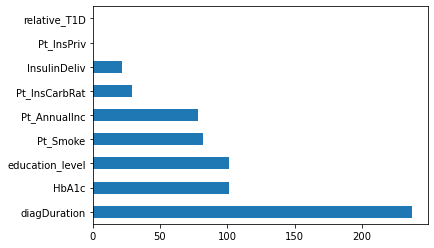

In [28]:
# feature importance graph of XGB
feat_importances = pd.Series(model.feature_importances_, index=X_train_copy.columns[0:204])
feat_importances.nlargest(20).plot(kind='barh')


In [29]:
# if is_male:
    
#     X_train.update(X_train[[
#                  'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
#                  'HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
#                  'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
#                  ]].fillna(0))

#     X_test.update(X_test[[
#                  'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
#                  'HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
#                  'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
#                  ]].fillna(0))

# else:
#     X_train.update(X_train[[
#              'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
#              'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
#              'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
#              ]].fillna(0))

#     X_test.update(X_test[[
#              'Pt_InsPriv','Pt_BolusDecCntCarb', 'Pt_HealthProfDiabEdu',
#              'Pt_MiscarriageNum','HyperglyCritRandGluc','NumDKAOccur','TannerNotDone',
#              'Pt_InsLev1PerDay','Pt_InsLev2PerDay','Pt_InsLant1PerDay','Pt_InsLant2PerDay'
#              ]].fillna(0))


In [30]:
# fill nan values in categorical dataset with frequent value

# tested wuth mean and median - results is lower than most_frequent
# imputeX = SimpleImputer(missing_values=np.nan, strategy = "most_frequent")
# imputeX = KNNImputer(missing_values=np.nan, n_neighbors = 3, weights='distance')


imputeX = IterativeImputer(missing_values=np.nan,sample_posterior= True,max_iter=15,
                           initial_strategy='most_frequent', random_state=0)

X_train = imputeX.fit_transform(X_train)

In [31]:
# ###############
# import datawig

# imputer = datawig.SimpleImputer()
# imputer.fit(train_df = X_train, num_epochs=50)
# X_test = imputer.predict(X_test)
# X_train = imputer.predict(X_train)

In [32]:
# test data imputation

Test = X_test.copy()
Test.loc[:,y_label] = Y_test

X_test = imputeX.transform(X_test)


# Scale data

In [33]:
# Normalize numeric features
scaler = StandardScaler()
# scaler = MinMaxScaler()
select = {}
# select[0] = pd.DataFrame(scaler.fit_transform(X_train))
# select[1] = Y_train
# select[2] = pd.DataFrame(scaler.transform(X_test))

select[0] = pd.DataFrame(X_train)
select[1] = Y_train
select[2] = pd.DataFrame(X_test)

## Feature Selection

In [34]:
# TODO

# def select_features(select, feature):
#     selected = {}
#     fs = SelectKBest(score_func=mutual_info_classif, k=feature) # k=feature score_func SelectPercentile
#     selected[0] = fs.fit_transform(select[0], select[1])
#     selected[1] = fs.transform(select[2])
        
#     idx = fs.get_support(indices=True)
    
#     return selected, fs, idx



In [35]:


#Selecting the Best important features according to Logistic Regression
# Give better performance than selectKBest 
def select_features(select, feature):
    selected = {}
#     fs = RFE(estimator=LogisticRegression(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    fs = RFE(estimator=XGBClassifier(), n_features_to_select=feature, step = 5) #  step (the number of features eliminated each iteration) 
#     fs = RFE(estimator=RandomForestClassifier(), n_features_to_select=feature, step = 1) #  step (the number of features eliminated each iteration) 
    
    
    selected[0] = fs.fit_transform(select[0], select[1])
    selected[1] = fs.transform(select[2])

    idx = fs.get_support(indices=True)
    
    return selected, fs, idx


In [36]:
# Feature selection
selected, fs, idx = select_features(select, feature)


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[03:03:39] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [37]:
# Get columns to keep and create new dataframe with those only
from pprint import pprint
cols = fs.get_support(indices=True)
features_df_new = original_X.iloc[:,cols]
pprint(features_df_new.columns)
print(features_df_new.shape)



Index(['diagDuration', 'HbA1c', 'Pt_AnnualInc', 'Pt_InsPriv',
       'education_level', 'InsulinDeliv', 'Pt_Smoke', 'Pt_InsCarbRat',
       'relative_T1D'],
      dtype='object')
(6655, 9)


In [38]:
X_train = pd.DataFrame(selected[0], columns = features_df_new.columns)
X_test = pd.DataFrame(selected[1], columns = features_df_new.columns)


In [39]:
# X_train.drop(['Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1)
# X_test.drop(['Pt_v3NumSHSeizComa', 'SHSeizComaPast12mos'], inplace=True, axis=1)

# if('Pt_SevHypoEver' in X_train.columns):
#     X_train = X_train.drop(['Pt_SevHypoEver'], axis=1)
#     X_test = X_test.drop(['Pt_SevHypoEver'], axis=1)
# if('NumSHSeizComaPast12mos' in X_train.columns):
#     X_train = X_train.drop(['NumSHSeizComaPast12mos'], axis=1)
#     X_test = X_test.drop([ 'NumSHSeizComaPast12mos'], axis=1)
    
# if('Pt_v3NumSHSeizComa' in X_train.columns):
#     X_train = X_train.drop(['Pt_v3NumSHSeizComa'], axis=1)
#     X_test = X_test.drop(['Pt_v3NumSHSeizComa'], axis=1)


### Common functions

In [40]:
# kf = KFold(n_splits= 3, shuffle=False)
train = X_train.copy()
train[y_label] = Y_train.values

def cross_val(model, n_splits=10):
#     i = 1
#     for train_index, test_index in kf.split(train):
#         X_train1 = train.iloc[train_index].loc[:, X_train.columns]
#         X_test1 = train.iloc[test_index][X_train.columns]
#         y_train1 = train.iloc[train_index].loc[:,y_label]
#         y_test1 = train.iloc[test_index][y_label]

#         #Train the model
#         model.fit(X_train1, y_train1) #Training the model
#         print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}")
#         i += 1
#     return model



    dfs = []
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=123)
    i = 1
    for train_index, test_index in kf.split(train, Y_train):
        X_train1 = train.iloc[train_index].loc[:, X_train.columns]
        X_test1 = train.iloc[test_index].loc[:,X_train.columns]
        y_train1 = train.iloc[train_index].loc[:,y_label]
        y_test1 = train.iloc[test_index].loc[:,y_label]

        #Train the model
        model.fit(X_train1, y_train1) #Training the model
        print(f"Accuracy for the fold no. {i} on the test set: {accuracy_score(y_test1, model.predict(X_test1))}, doublecheck: {model.score(X_test1,y_test1)}")

        # how many occurances appear in the train set
        s_train = train.iloc[train_index].loc[:,y_label].value_counts()
        s_train.name = f"train {i}"
        s_test = train.iloc[test_index].loc[:,y_label].value_counts()
        s_test.name = f"test {i}"
        df = pd.concat([s_train, s_test], axis=1, sort=False)
        df["|"] = "|"
        dfs.append(df)

        i += 1
    return model



In [41]:
def optimal_thresh(model, X, Y):
    y_scores = model.predict_proba(X)[:,1]

    fpr, tpr, thresholds = roc_curve(Y, y_scores)
    print(roc_auc_score(Y, y_scores))
#     optimal_idx = np.argmax(sqrt(tpr * (1-fpr)))
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Threshold value is:", optimal_threshold)
    plot_roc_curve(fpr, tpr, optimal_idx)
    plt.show()
    return optimal_threshold

In [42]:
def train_results(model, X_train, Y_train, pred_train):
    print("\n \n =====================   Train Dataset    ======================")

    print(accuracy_score(Y_train, pred_train)*100)

    confusion_matrix_train = pd.DataFrame(confusion_matrix(Y_train, pred_train))
    sns.heatmap(confusion_matrix_train, annot=True,fmt='g')
    print(classification_report(Y_train, pred_train))
    plt.show()
    
    train_acc = model.score(X_train, Y_train)
    print('Accuracy of on training set: {:.2f}'.format(train_acc))

def test_results(model, X_test, Y_test, pred):
    print("\n\n =====================   Test Dataset    =======================")

    print(accuracy_score(Y_test, pred)*100)

    confusion_matrix_model = confusion_matrix(Y_test, pred)
    sns.heatmap(confusion_matrix_model, annot=True,fmt='g')
    print(classification_report(Y_test, pred))
    plt.show()
    
    test_acc = model.score(X_test, Y_test)
    print('Accuracy of classifier on test set: {:.2f}'
         .format(test_acc))

def ROC_results(model, X_test, Y_test):
    print("\n\n =======================   Test-ROC    =========================")

    y_scores = model.predict_proba(X_test)
    score = roc_auc_score(Y_test, y_scores[:, 1])
    score = round(score,4)
    print(f'roc_auc = {score}')
    
def class_wise_test_accuracy(model, Y_test, pred):
    print("\n\n =======================   Class-wise test accuracy    =====================")
    confusion_matrix_model = confusion_matrix(Y_test, pred)
    acc = confusion_matrix_model.diagonal()/confusion_matrix_model.sum(axis=1)
    print('classwise accuracy [class 0, class 1]: ',(acc))
    print('average accuracy: ',( np.sum(acc)/2))
    
    print('f1', metrics.f1_score(pred, Y_test))    

Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 8 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Train ROC
0.8008035999559671
Threshold value is: 0.9650135428271605

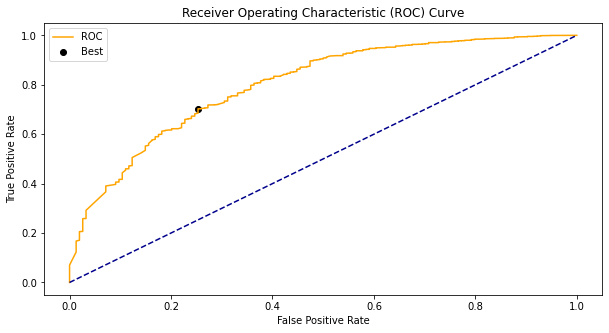

Test ROC
0.6113076352673741
Threshold value is: 0.9665883231317067


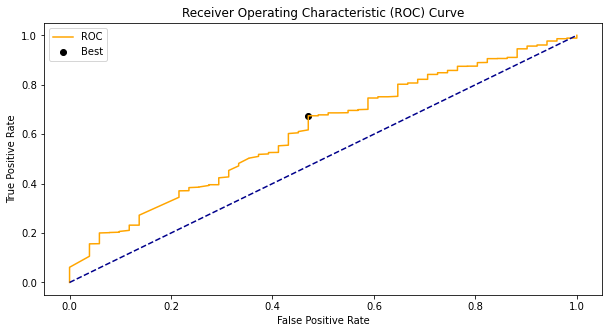


 
 =====================   Train Dataset    ======================
70.40673211781207
              precision    recall  f1-score   support

         0.0       0.07      0.75      0.13       154
         1.0       0.99      0.70      0.82      4837

    accuracy                           0.70      4991
   macro avg       0.53      0.72      0.48      4991
weighted avg       0.96      0.70      0.80      4991



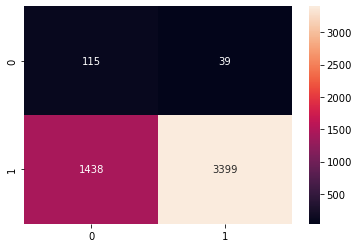

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
67.00721153846155
              precision    recall  f1-score   support

         0.0       0.05      0.53      0.09        51
         1.0       0.98      0.67      0.80      1613

    accuracy                           0.67      1664
   macro avg       0.51      0.60      0.44      1664
weighted avg       0.95      0.67      0.78      1664



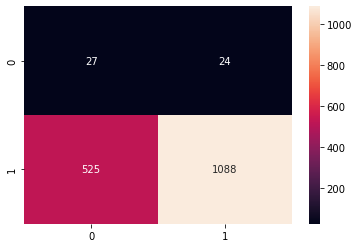

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.6113


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.52941176 0.67451953]
average accuracy:  0.6019656467670763
f1 0.7985321100917432


In [43]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

ltb_model=ltb.LGBMClassifier(use_missing = False,
                         learning_rate = 0.01, 
                         max_depth =4, random_state=0 )
# adaboost.fit(X_train, Y_train)
ltb_model = cross_val(ltb_model, 10)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(ltb_model, X_train, Y_train)
pred_train = (ltb_model.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)
print("Test ROC")
optimal_threshold = optimal_thresh(ltb_model, X_test, Y_test)
pred = (ltb_model.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# test and train results
train_results(ltb_model, X_train, Y_train, pred_train)
test_results(ltb_model, X_test, Y_test, pred)

# ROC
ROC_results(ltb_model, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(ltb_model, Y_test, pred)


<AxesSubplot:>

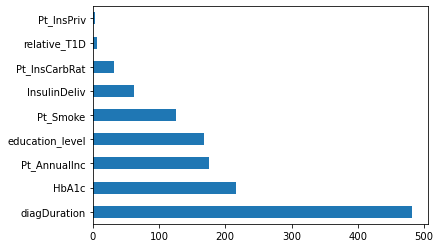

In [44]:
feat_importances = pd.Series(ltb_model.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

In [45]:
def draw_boundary(model, X, Y, thresh1, thresh2):
    
    prediction = (model.predict_proba(X)[:,1])
    
    X_axis= np.linspace(start = 0, stop = 1, num = len(prediction))
    d = pd.DataFrame(prediction, columns=['pre'])
    X_axis = pd.DataFrame(X_axis, columns=['x_axis_vals'])
    df = pd.concat([d.reset_index(drop=True), Y.reset_index(drop=True)], axis=1)
    df = pd.concat([df.reset_index(drop=True), X_axis.reset_index(drop=True)], axis=1)
    
    
    # plot histogram
    plt.figure(figsize=(15,7))
    plt.hist(prediction[Y==0], bins=50, label='Positive', alpha=1, color='b', density=True)
    plt.hist(prediction[Y==1], bins=50, label='Negative', alpha=0.5, color='r', density=True)
    plt.xlabel('Probability of being Positive Class', fontsize=10)
    plt.ylabel('Number of records in each bucket', fontsize=10)
    plt.legend(fontsize=10)
    plt.tick_params(axis='both', labelsize=10, pad=5)
    plt.show() 
    
    # plot scatter
    plt.figure(figsize=(16, 16))
    colormap = np.array(['k', 'y'])
    cs = df.SHSeizComaPast12mos.to_list()
    categories = np.array(cs).astype(int)
    plt.scatter(df.x_axis_vals, df.pre, s=100, c=colormap[categories], alpha=0.5)
    plt.axhline(y=thresh1, color = 'r')
    plt.axhline(y=thresh2, color = 'g')
    plt.xlabel('sample', fontsize=10)
    plt.ylabel('probability', fontsize=10)
    plt.show()

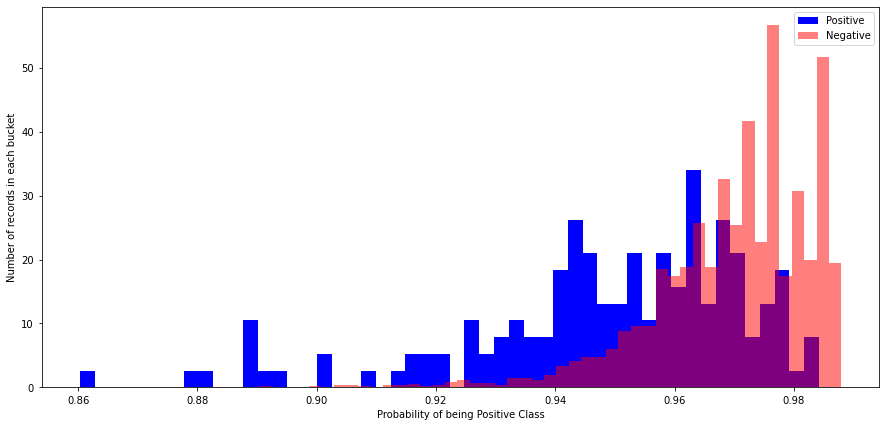

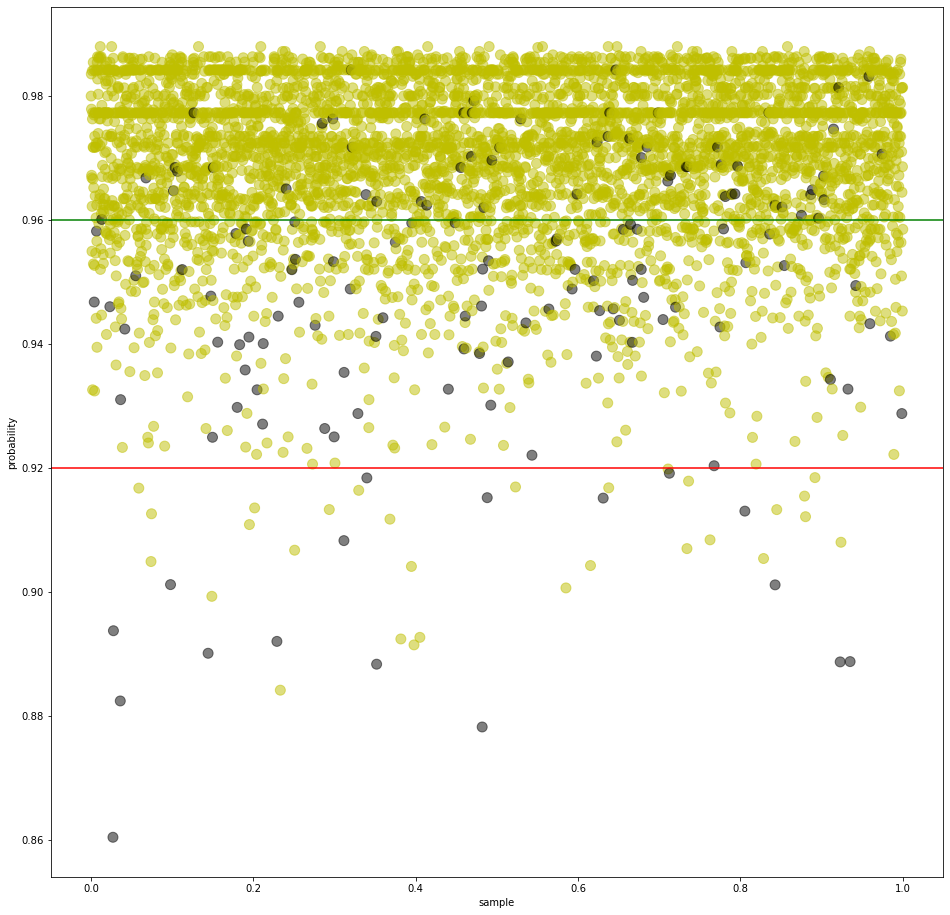

In [46]:
patients_count = X_train.shape[0]

def get_optimal_threshold(model, X, full_cost, single_cost):
    threshold = 0.0
    no_patients = int(full_cost / single_cost)
    if no_patients > patients_count:
        threshold = 0.85
    else:
        prediction = (model.predict_proba(X)[:,1])
        prediction = np.sort(prediction)
        threshold = np.round(prediction[no_patients-1],2)
    return threshold
    
thresh1 = get_optimal_threshold(ltb_model, X_train, 8000, 200)
thresh2 = 0.96
draw_boundary(ltb_model, X_train, Y_train, thresh1, thresh2)

In [47]:
def get_decision_boundaries(prob, thresh1, thresh2):
    label = ''
    if(prob < thresh1):
        label = 'high risk'
    elif(prob < thresh2):
        label = 'risk'
    else:
        label = 'low risk'
    return label


In [48]:

row_to_show = 93
data_for_prediction = X_test.iloc[row_to_show]  # use 1 row of data here. Could use multiple rows if desired
data_for_prediction_array = data_for_prediction.values.reshape(1, -1)

pred = (ltb_model.predict_proba(data_for_prediction_array)[:,1] >= optimal_threshold).astype(int)
print('predictoin', pred)
print('actial', Y_test.iloc[row_to_show])
ltb_model.predict_proba(data_for_prediction_array)

# Create object that can calculate shap values
explainer = shap.TreeExplainer(ltb_model)
# Calculate Shap values
shap_values = explainer.shap_values(data_for_prediction_array)
shap.initjs()
# The shap_values object above is a list with two arrays.
# The first array is the SHAP values for a negative outcome (have disease), 
# second array is the list of SHAP values for the positive outcome (don't have the disease).
# SHAP values for positive outcomes (pulling out shap_values[1]).
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction, link='logit')

predictoin [1]
actial 1.0


Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


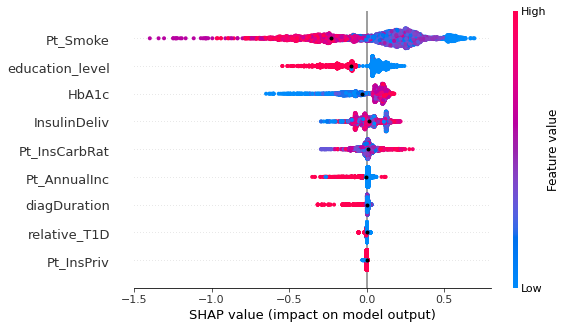

In [49]:
# compute SHAP values
explainer = shap.Explainer(ltb_model, X_train)
shap_values = explainer(X_train)

import matplotlib.pyplot as pl
shap.plots.beeswarm(shap_values, show=False)
shap.plots.beeswarm(shap_values[-1:], show=False, color="black")
pl.show()

In [50]:
pred = ltb_model.predict_proba(X_train)[:,1] 
Y_train = pd.DataFrame(Y_train)
X_beeswarm = X_train.copy()
X_beeswarm['pred'] = pred
# X_beeswarm['Y'] = Y_train
X_beeswarm['Y'] = Y_train[y_label].to_list()

In [51]:
idx = np.where((X_beeswarm['pred']>thresh2) & (X_beeswarm['Y']== 0.0) )
print(idx)

idx2 = np.where((X_beeswarm['pred']<0.85) & (X_beeswarm['Y']== 0.0) )
print(idx2)

# negative case in positive side
idx3 = np.where((X_beeswarm['pred']<0.85) & (X_beeswarm['Y']== 1.0) )
print(idx3)

X_beeswarm.drop(['pred'], axis = 1)
X_beeswarm.drop(['Y'], axis = 1)

explainer = shap.Explainer(ltb_model, X_beeswarm)
shap_values = explainer(X_beeswarm)



(array([  65,  337,  506,  516,  531,  632,  751, 1199, 1421, 1486, 1600,
       1605, 1690, 1756, 2030, 2052, 2063, 2273, 2291, 2338, 2343, 2353,
       2414, 2464, 2512, 2642, 2987, 3111, 3178, 3188, 3226, 3311, 3384,
       3418, 3487, 3545, 3562, 3659, 3666, 3851, 3874, 3899, 3938, 3958,
       3975, 4167, 4204, 4248, 4367, 4424, 4434, 4472, 4503, 4506, 4564,
       4596, 4782, 4863]),)
(array([], dtype=int64),)
(array([], dtype=int64),)


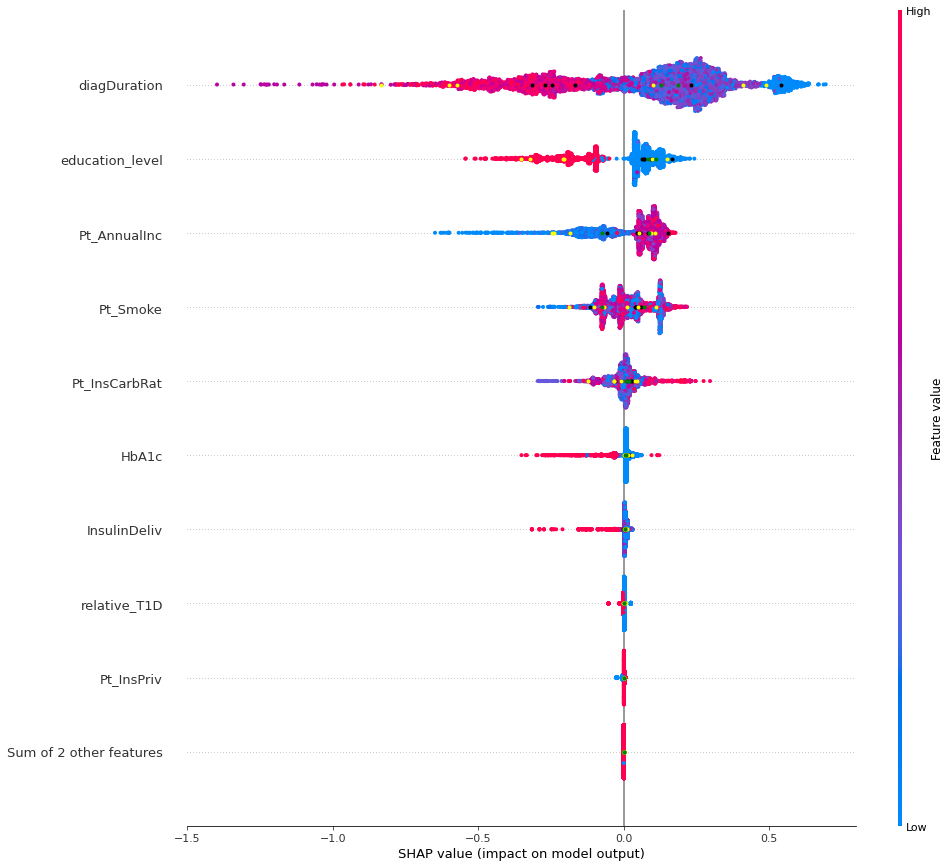

In [52]:

shap.plots.beeswarm(shap_values, show=False, plot_size=[15,15], alpha = 1)
shap.plots.beeswarm(shap_values[402:403:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[760:761:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[840:841:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[1243:1244:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[1395:1396:], show=False, color="black", plot_size=[15,15])
shap.plots.beeswarm(shap_values[1558:1559:], show=False, color="black", plot_size=[15,15])


shap.plots.beeswarm(shap_values[179:180:], show=False, color="yellow", plot_size=[15,15])
shap.plots.beeswarm(shap_values[192:193:], show=False, color="yellow", plot_size=[15,15])
shap.plots.beeswarm(shap_values[334:335:], show=False, color="yellow", plot_size=[15,15])
shap.plots.beeswarm(shap_values[348:349:], show=False, color="yellow", plot_size=[15,15])
shap.plots.beeswarm(shap_values[413:414:], show=False, color="yellow", plot_size=[15,15])
shap.plots.beeswarm(shap_values[425:426:], show=False, color="yellow", plot_size=[15,15])

shap.plots.beeswarm(shap_values[1427:1428:], show=False, color="green", plot_size=[15,15])
shap.plots.beeswarm(shap_values[2212:2213:], show=False, color="green", plot_size=[15,15])


plt.show()


### Adaboost model

Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 8 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Train ROC
0.7095454679701113
Threshold value is: 0.6058018193405827

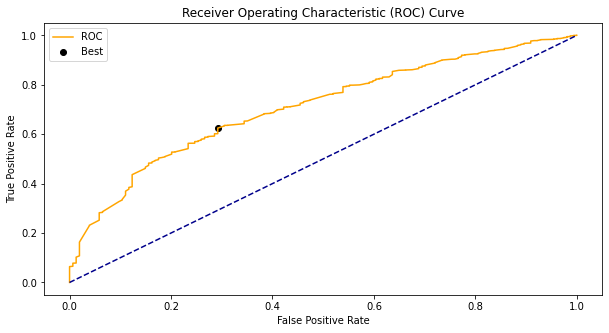

Test ROC
0.5949090113416725
Threshold value is: 0.6112880314555287


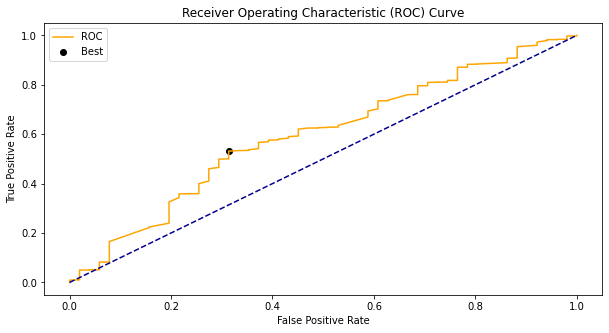


 
 =====================   Train Dataset    ======================
62.732919254658384
              precision    recall  f1-score   support

         0.0       0.06      0.71      0.10       154
         1.0       0.99      0.62      0.76      4837

    accuracy                           0.63      4991
   macro avg       0.52      0.67      0.43      4991
weighted avg       0.96      0.63      0.74      4991



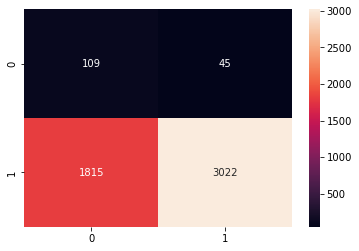

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
53.605769230769226
              precision    recall  f1-score   support

         0.0       0.04      0.69      0.08        51
         1.0       0.98      0.53      0.69      1613

    accuracy                           0.54      1664
   macro avg       0.51      0.61      0.39      1664
weighted avg       0.95      0.54      0.67      1664



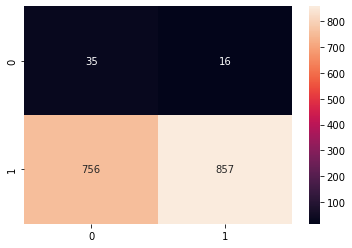

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.5949


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.68627451 0.53130812]
average accuracy:  0.6087913156583153
f1 0.6894609814963798


In [53]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_validate, cross_val_score

adaboost = AdaBoostClassifier(random_state=0,
                              learning_rate=0.008,
                              n_estimators=1000,
                              algorithm = "SAMME.R") #algorithm{‘SAMME’, ‘SAMME.R’}, default=’SAMME.R’

# adaboost.fit(X_train, Y_train)
adaboost = cross_val(adaboost, 10)

# pred=adaboost.predict(X_test)
# pred_train=adaboost.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(adaboost, X_train, Y_train)
pred_train = (adaboost.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)
print("Test ROC")
optimal_threshold = optimal_thresh(adaboost, X_test, Y_test)
pred = (adaboost.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# test and train results
train_results(adaboost, X_train, Y_train, pred_train)
test_results(adaboost, X_test, Y_test, pred)

# ROC
ROC_results(adaboost, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(adaboost, Y_test, pred)


<AxesSubplot:>

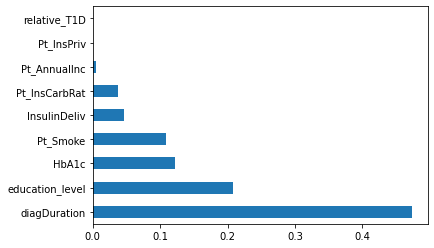

In [54]:
feat_importances = pd.Series(adaboost.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

# Model - XGB

Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 7 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 8 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Train ROC
0.9454019207998947
Threshold value is: 1.9281716


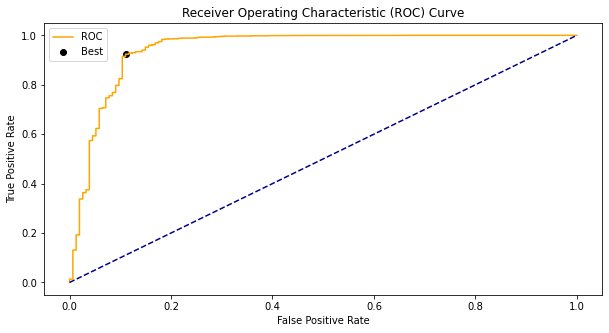

Test ROC
0.6052903492457119
Threshold value is: 2.704735


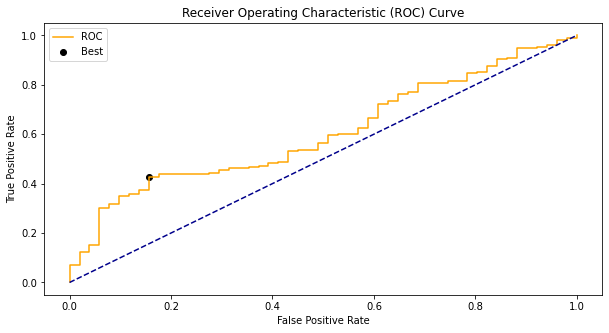


 
 =====================   Train Dataset    ======================
92.26607894209577
              precision    recall  f1-score   support

         0.0       0.27      0.89      0.42       154
         1.0       1.00      0.92      0.96      4837

    accuracy                           0.92      4991
   macro avg       0.63      0.91      0.69      4991
weighted avg       0.97      0.92      0.94      4991



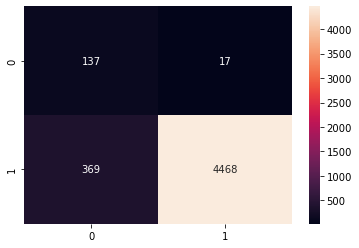

Accuracy of on training set: 0.98


 =====================   Test Dataset    =======================
43.87019230769231
              precision    recall  f1-score   support

         0.0       0.04      0.84      0.08        51
         1.0       0.99      0.43      0.60      1613

    accuracy                           0.44      1664
   macro avg       0.52      0.63      0.34      1664
weighted avg       0.96      0.44      0.58      1664



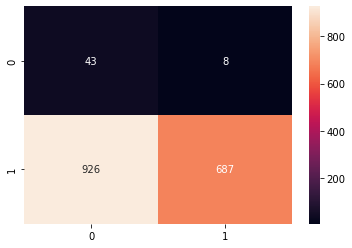

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.6053


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.84313725 0.42591445]
average accuracy:  0.6345258500176264
f1 0.5953206239168112


In [55]:
# xgboost - train with missing values


xgb_impute=XGBClassifier(
        use_label_encoder=False,
        eta = 0.1,#eta between(0.01-0.2)
        max_depth = 6, #values between(3-10)
#         max_delta_step = 10,
#         subsample = 0.5,#values between(0.5-1)
#         colsample_bytree = 1,#values between(0.5-1)
#         tree_method = "auto",
#         process_type = "default",
#         num_parallel_tree=7,
        objective='multi:softmax',
#         min_child_weight = 3,
        booster='gbtree',
        eval_metric = "mlogloss",
        num_class = n_classes
        )
        
# xgb_impute.fit(X_train,Y_train)
xgb_impute = cross_val(xgb_impute,10)

# xgb_pred=xgb_impute.predict(X_test)
# xgb_pred_train=xgb_impute.predict(X_train)


# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(xgb_impute, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(xgb_impute, X_test, Y_test)

xgb_pred = (xgb_impute.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
xgb_pred_train = (xgb_impute.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(xgb_impute, X_train, Y_train, xgb_pred_train)
test_results(xgb_impute, X_test, Y_test, xgb_pred)

# ROC
ROC_results(xgb_impute, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(xgb_impute, Y_test, xgb_pred)



<AxesSubplot:>

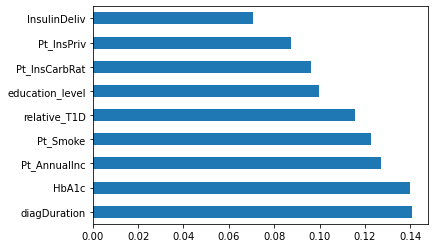

In [56]:
# feature importance graph of XGB
feat_importances = pd.Series(xgb_impute.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 2 - Random forest

Accuracy for the fold no. 1 on the test set: 0.684, doublecheck: 0.684
Accuracy for the fold no. 2 on the test set: 0.6893787575150301, doublecheck: 0.6893787575150301
Accuracy for the fold no. 3 on the test set: 0.7014028056112225, doublecheck: 0.7014028056112225
Accuracy for the fold no. 4 on the test set: 0.7535070140280561, doublecheck: 0.7535070140280561
Accuracy for the fold no. 5 on the test set: 0.7014028056112225, doublecheck: 0.7014028056112225
Accuracy for the fold no. 6 on the test set: 0.7314629258517034, doublecheck: 0.7314629258517034
Accuracy for the fold no. 7 on the test set: 0.7094188376753507, doublecheck: 0.7094188376753507
Accuracy for the fold no. 8 on the test set: 0.685370741482966, doublecheck: 0.685370741482966
Accuracy for the fold no. 9 on the test set: 0.7194388777555111, doublecheck: 0.7194388777555111
Accuracy for the fold no. 10 on the test set: 0.7394789579158316, doublecheck: 0.7394789579158316
Train ROC
0.7753276287491712
Threshold value is: 0.542945

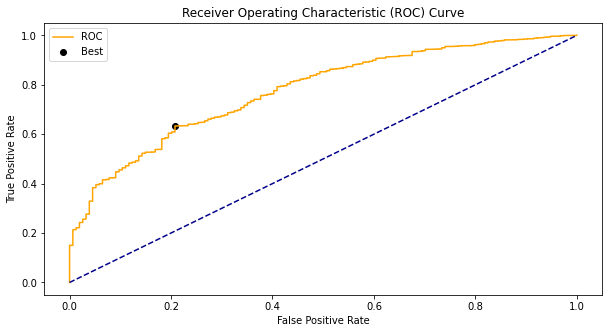

Test ROC
0.6403972624387636
Threshold value is: 0.4969544511790977


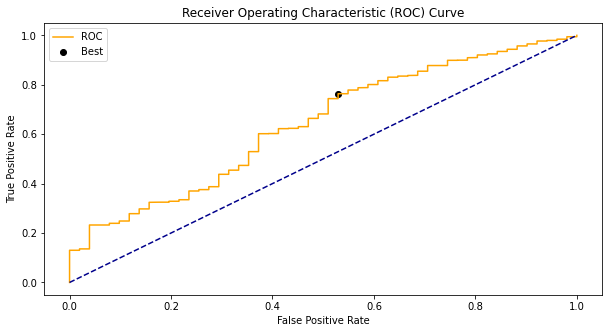


 
 =====================   Train Dataset    ======================
63.8148667601683
              precision    recall  f1-score   support

         0.0       0.06      0.79      0.12       154
         1.0       0.99      0.63      0.77      4837

    accuracy                           0.64      4991
   macro avg       0.53      0.71      0.45      4991
weighted avg       0.96      0.64      0.75      4991



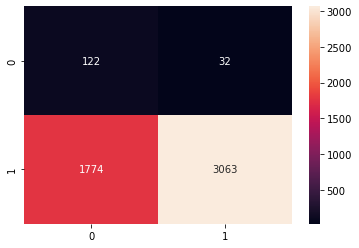

Accuracy of on training set: 0.74


 =====================   Test Dataset    =======================
75.48076923076923
              precision    recall  f1-score   support

         0.0       0.06      0.47      0.11        51
         1.0       0.98      0.76      0.86      1613

    accuracy                           0.75      1664
   macro avg       0.52      0.62      0.48      1664
weighted avg       0.95      0.75      0.83      1664



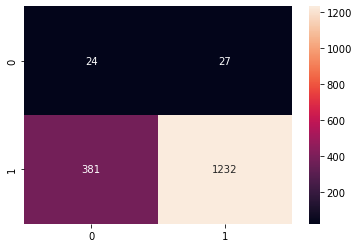

Accuracy of classifier on test set: 0.75


 =======================   Test-ROC    =========================
roc_auc = 0.6404


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.47058824 0.76379417]
average accuracy:  0.6171912038218883
f1 0.8579387186629526


In [57]:
#  random forest classifier

rf=RandomForestClassifier(max_depth=5,
                             n_estimators = feature,
                             criterion = 'entropy', # {“gini”, “entropy”}, default=”gini”
                             class_weight = 'balanced_subsample', # {“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
                             ccp_alpha=0.01,
                             random_state=0)

# rf.fit(X_train,Y_train)
rf = cross_val(rf,10)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(rf, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(rf, X_test, Y_test)

# pred=rf.predict(X_test)
pred = (rf.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)

# pred_train=rf.predict(X_train)
pred_train = (rf.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(rf, X_train, Y_train, pred_train)
test_results(rf, X_test, Y_test, pred)

# ROC
ROC_results(rf, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(rf, Y_test, pred)

<AxesSubplot:>

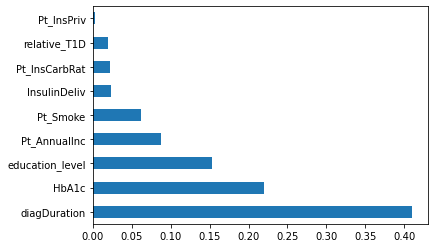

In [58]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

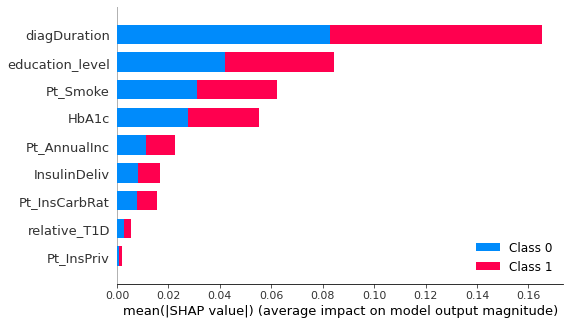

In [59]:
shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train)

## Model 3 LogisticRegression

l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 1 on the test set: 0.602, doublecheck: 0.602
Accuracy for the fold no. 2 on the test set: 0.7094188376753507, doublecheck: 0.7094188376753507
Accuracy for the fold no. 3 on the test set: 0.6072144288577155, doublecheck: 0.6072144288577155


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 4 on the test set: 0.6492985971943888, doublecheck: 0.6492985971943888
Accuracy for the fold no. 5 on the test set: 0.6593186372745491, doublecheck: 0.6593186372745491
Accuracy for the fold no. 6 on the test set: 0.6813627254509018, doublecheck: 0.6813627254509018


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)


Accuracy for the fold no. 7 on the test set: 0.6192384769539078, doublecheck: 0.6192384769539078
Accuracy for the fold no. 8 on the test set: 0.6152304609218436, doublecheck: 0.6152304609218436
Accuracy for the fold no. 9 on the test set: 0.5490981963927856, doublecheck: 0.5490981963927856


The max_iter was reached which means the coef_ did not converge
l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
The max_iter was reached which means the coef_ did not converge


Accuracy for the fold no. 10 on the test set: 0.6132264529058116, doublecheck: 0.6132264529058116
Train ROC
0.6526088135556815
Threshold value is: 0.5200149106890294


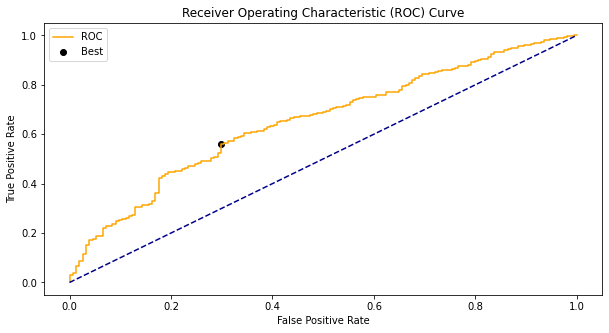

Test ROC
0.6400690468375818
Threshold value is: 0.47012296782854374


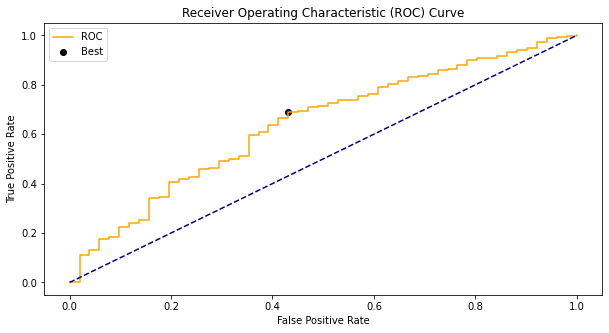


 
 =====================   Train Dataset    ======================
56.58184732518533
              precision    recall  f1-score   support

         0.0       0.05      0.70      0.09       154
         1.0       0.98      0.56      0.71      4837

    accuracy                           0.57      4991
   macro avg       0.52      0.63      0.40      4991
weighted avg       0.95      0.57      0.70      4991



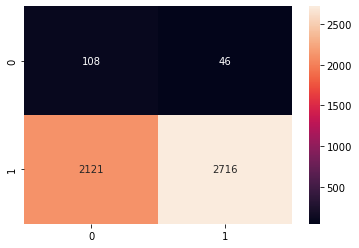

Accuracy of on training set: 0.61


 =====================   Test Dataset    =======================
68.50961538461539
              precision    recall  f1-score   support

         0.0       0.05      0.57      0.10        51
         1.0       0.98      0.69      0.81      1613

    accuracy                           0.69      1664
   macro avg       0.52      0.63      0.45      1664
weighted avg       0.95      0.69      0.79      1664



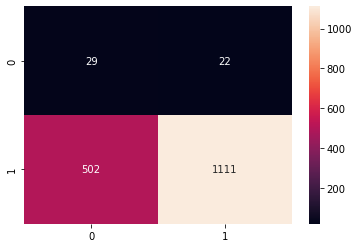

Accuracy of classifier on test set: 0.61


 =======================   Test-ROC    =========================
roc_auc = 0.6401


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.56862745 0.68877867]
average accuracy:  0.6287030621299976
f1 0.8091769847050254


In [60]:
#penalty{‘l1’, ‘l2’, ‘elasticnet’, ‘none’}, default=’l2’
logreg = LogisticRegression(
    penalty='l2',
    tol = 5e-4,
    C=1,
    l1_ratio = 10,
    class_weight='balanced',  # balanced
    random_state=0,
    solver = 'saga' # saga, sag
)

# logreg.fit(X_train, Y_train)
logreg = cross_val(logreg,10)

# pred=logreg.predict(X_test)
# pred_train=logreg.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(logreg, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(logreg, X_test, Y_test)

pred = (logreg.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (logreg.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(logreg, X_train, Y_train, pred_train)
test_results(logreg, X_test, Y_test, pred)

# ROC
ROC_results(logreg, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(logreg, Y_test, pred)

<AxesSubplot:>

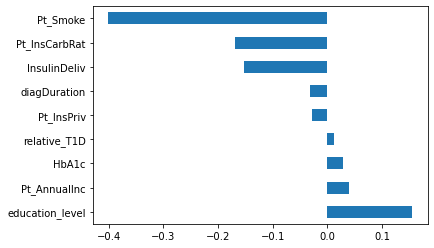

In [61]:

feat_importances = pd.Series(logreg.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 6 - Linear Discriminant Analysis

Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 8 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Train ROC
0.6544184572921394
Threshold value is: 0.9711538108079951

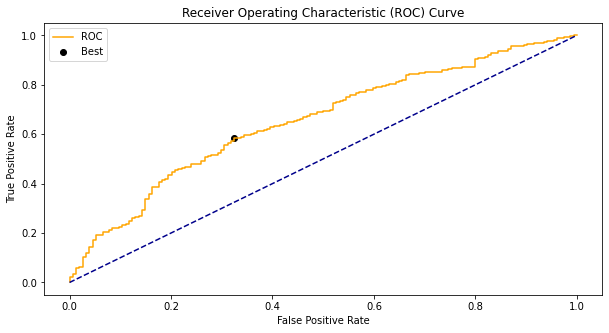

Test ROC
0.6402149204381071
Threshold value is: 0.9665922607356412


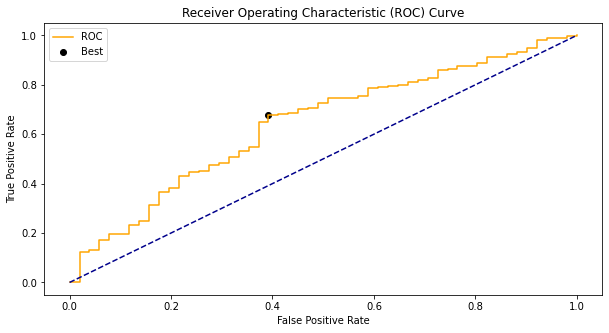


 
 =====================   Train Dataset    ======================
58.54538168703667
              precision    recall  f1-score   support

         0.0       0.05      0.68      0.09       154
         1.0       0.98      0.58      0.73      4837

    accuracy                           0.59      4991
   macro avg       0.52      0.63      0.41      4991
weighted avg       0.95      0.59      0.71      4991



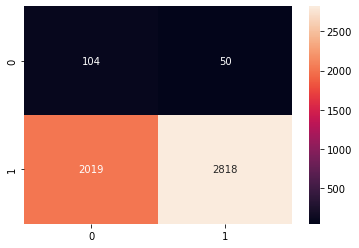

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
67.60817307692307
              precision    recall  f1-score   support

         0.0       0.06      0.61      0.10        51
         1.0       0.98      0.68      0.80      1613

    accuracy                           0.68      1664
   macro avg       0.52      0.64      0.45      1664
weighted avg       0.95      0.68      0.78      1664



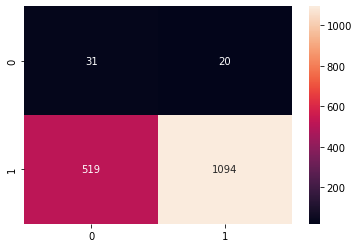

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.6402


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.60784314 0.67823931]
average accuracy:  0.6430412214482817
f1 0.8023469013568023


In [62]:

lda = LinearDiscriminantAnalysis(
    solver = 'eigen', # solver{‘svd’, ‘lsqr’, ‘eigen’}, default=’svd’
    shrinkage= 'auto', #shrinkage‘auto’ or float, default=None
    n_components = 1,
    tol = 1e-3                       
)
# lda.fit(X_train, Y_train)
lda = cross_val(lda)

# pred=lda.predict(X_test)
# pred_train=lda.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(lda, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(lda, X_test, Y_test)

pred = (lda.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (lda.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)

train_results(lda, X_train, Y_train, pred_train)
test_results(lda, X_test, Y_test, pred)

# ROC
ROC_results(lda, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(lda, Y_test, pred)


<AxesSubplot:>

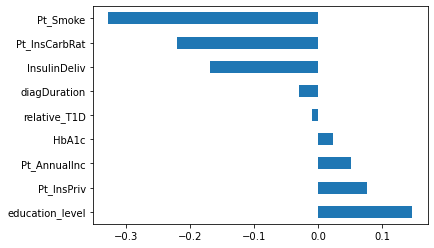

In [63]:


feat_importances = pd.Series(lda.coef_[0], index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')

## Model 7- Gaussian Naive Bayes

Accuracy for the fold no. 1 on the test set: 0.968, doublecheck: 0.968
Accuracy for the fold no. 2 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 3 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 4 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 5 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 6 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 7 on the test set: 0.969939879759519, doublecheck: 0.969939879759519
Accuracy for the fold no. 8 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 9 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Accuracy for the fold no. 10 on the test set: 0.9679358717434869, doublecheck: 0.9679358717434869
Train ROC
0.6079503502492958
Threshold value is: 0.969532031063132


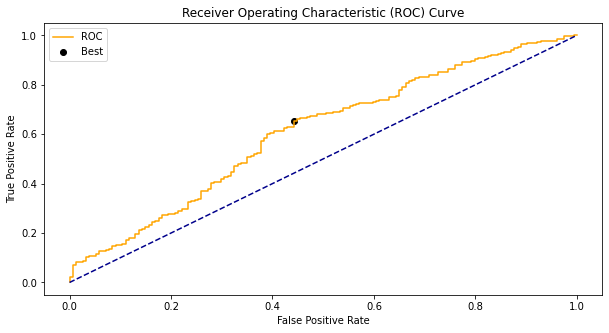

Test ROC
0.6121464084703936
Threshold value is: 0.9699009819519395


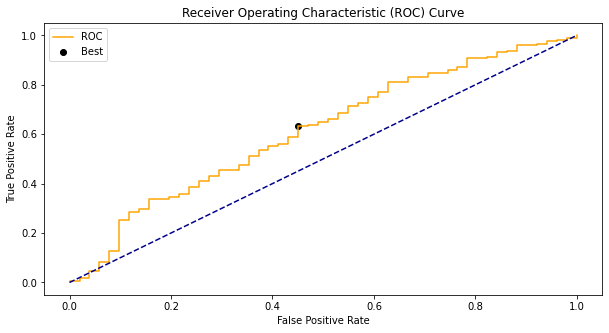


 
 =====================   Train Dataset    ======================
65.23742736926468
              precision    recall  f1-score   support

         0.0       0.05      0.56      0.09       154
         1.0       0.98      0.66      0.79      4837

    accuracy                           0.65      4991
   macro avg       0.51      0.61      0.44      4991
weighted avg       0.95      0.65      0.76      4991



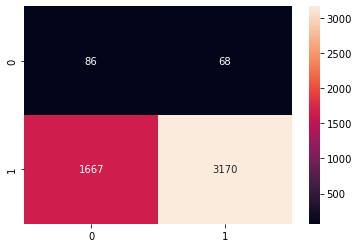

Accuracy of on training set: 0.97


 =====================   Test Dataset    =======================
63.161057692307686
              precision    recall  f1-score   support

         0.0       0.05      0.55      0.08        51
         1.0       0.98      0.63      0.77      1613

    accuracy                           0.63      1664
   macro avg       0.51      0.59      0.43      1664
weighted avg       0.95      0.63      0.75      1664



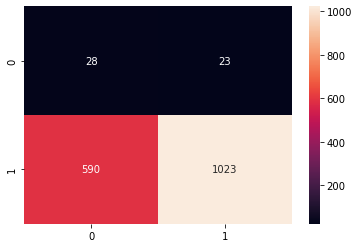

Accuracy of classifier on test set: 0.97


 =======================   Test-ROC    =========================
roc_auc = 0.6121


 =======================   Class-wise test accuracy    =====================
classwise accuracy [class 0, class 1]:  [0.54901961 0.63422195]
average accuracy:  0.5916207772631681
f1 0.7694622038360286


In [64]:
gnb = GaussianNB(priors=None, var_smoothing=1)
gnb = cross_val(gnb)
# gnb.fit(X_train, Y_train)
      
# pred=gnb.predict(X_test)
# pred_train=gnb.predict(X_train)

# find optimal threshold
print("Train ROC")
optimal_threshold_train= optimal_thresh(gnb, X_train, Y_train)
print("Test ROC")
optimal_threshold = optimal_thresh(gnb, X_test, Y_test)

pred = (gnb.predict_proba(X_test)[:,1] >= optimal_threshold).astype(int)
pred_train = (gnb.predict_proba(X_train)[:,1] >= optimal_threshold_train).astype(int)


train_results(gnb, X_train, Y_train, pred_train)
test_results(gnb, X_test, Y_test, pred)

# ROC
ROC_results(gnb, X_test, Y_test)

# class wise accuracy
class_wise_test_accuracy(gnb, Y_test, pred)


<AxesSubplot:>

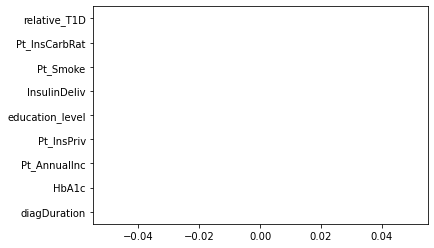

In [65]:
from sklearn.inspection import permutation_importance
imps = permutation_importance(gnb, X_test, Y_test)

feat_importances = pd.Series(imps.importances_mean, index=X_train.columns[0:feature])
feat_importances.nlargest(20).plot(kind='barh')